# Building a mask-face classification model using custom CNN

This notebook would build, train, and evaluate a custom hand-made CNN model for masked faces classification. We will try different scenarios to improve the result.

## Preparation

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

print("\u2022 Using TensorFlow Version:", tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.5.0
• GPU Device Found.


In [4]:
# DATASET_DIR = '/content/drive/MyDrive/capstone_machine_learning/masked_face_classification/dataset/arranged_dataset' # Change based on dataset dir on your system/device
DATASET_DIR = '/content/drive/MyDrive/capstone_machine_learning/masked_face_classification/dataset/kaggle/kaggle_dataset_3' # Change based on dataset dir on your system/device
MODEL_DIR = "/content/drive/MyDrive/capstone_machine_learning/masked_face_classification/notebooks/Saved_Models" # Change based on dataset dir on your system/device
TRAIN_DIR = os.path.join(DATASET_DIR, 'Train')
VAL_DIR = os.path.join(DATASET_DIR, 'Validation')
TEST_DIR = os.path.join(DATASET_DIR, 'Test')
BATCH_SIZE = 128

## Load images using ImageDataGenerator

In [5]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized
        batch_size=BATCH_SIZE,
        classes=['Non Mask', 'Mask'],
        class_mode='binary')

val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        shuffle=False,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        classes=['Non Mask', 'Mask'],
        class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        shuffle=False,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        classes=['Non Mask', 'Mask'],
        class_mode='binary')

Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


## Debug dataset generators

In [ ]:
# list(dir(train_generator)) # to know what attributes and methods the generator has

In [6]:
print('Number of classes:', train_generator.num_classes)
print('Class map:', train_generator.class_indices)
print('Auto-shuffle:', train_generator.shuffle, end='\n\n')

print('Number of classes:', val_generator.num_classes)
print('Class map:', val_generator.class_indices)
print('Auto-shuffle:', val_generator.shuffle, end='\n\n')

print('Number of classes:', test_generator.num_classes)
print('Class map:', test_generator.class_indices)
print('Auto-shuffle:', test_generator.shuffle, end='\n\n')

Number of classes: 2
Class map: {'Non Mask': 0, 'Mask': 1}
Auto-shuffle: True

Number of classes: 2
Class map: {'Non Mask': 0, 'Mask': 1}
Auto-shuffle: False

Number of classes: 2
Class map: {'Non Mask': 0, 'Mask': 1}
Auto-shuffle: False



Train samples
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


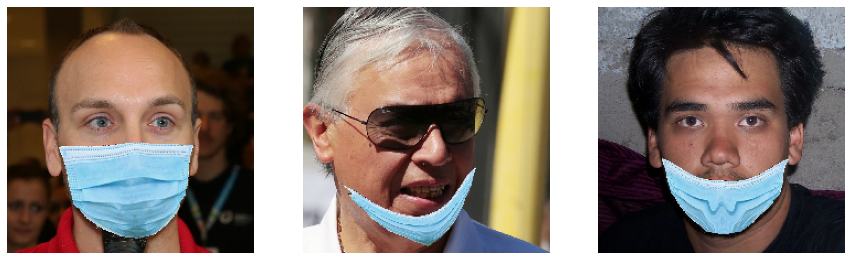

Validation samples
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


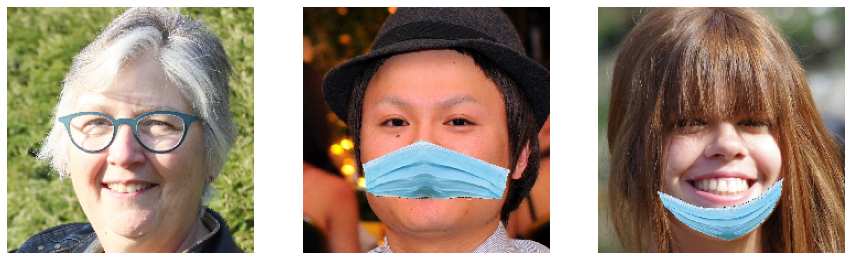

Test samples
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


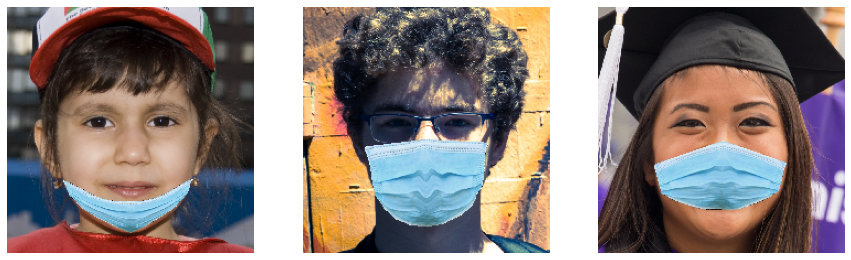

In [ ]:
# Sample some images in data generator to display

def display_samples(generator):
  '''
  Source: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
  '''
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
  for i in range(3):

    image = next(generator)[0][0]
    print(image.shape)

    ax[i].imshow(image)
    ax[i].axis('off')
  fig.show()
  plt.show()

print('Train samples')
display_samples(train_generator)
print('Validation samples')
display_samples(val_generator)
print('Test samples')
display_samples(test_generator)

## Build Model with Hand-Made CNN Scenario 1

In this scenario, we'd create a model with a series of `2D Convolutions` and `2D Max Poolings`, a `Flatten` layer, and followed by a bunch of `Dense` FC layers to see improvement over using `MobileNetV3Large`. Model would be compiled using `Categorical Crossentropy` loss, `Adam` optimizer, and `accuracy` metric. Because it contains relatively more shallow networks, we increase the training epochs to 20.

In [ ]:
model = tf.keras.models.Sequential([
    # Your Code Here
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(4,4),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
print(model.summary())

# Compile Model. 
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)             

In [ ]:
steps_train = train_generator.n//BATCH_SIZE
steps_val = val_generator.n//BATCH_SIZE

history = model.fit(
    train_generator,
    steps_per_epoch=steps_train,
    validation_data=val_generator,
    validation_steps=steps_val,
    shuffle=True,
    epochs=20,
    verbose=1
)

Epoch 1/20
78/78 [==============================] - 4557s 58s/step - loss: 0.9668 - accuracy: 0.5776 - val_loss: 0.0939 - val_accuracy: 0.9734
Epoch 2/20
78/78 [==============================] - 302s 4s/step - loss: 0.1043 - accuracy: 0.9708 - val_loss: 0.0662 - val_accuracy: 0.9807
Epoch 3/20
78/78 [==============================] - 300s 4s/step - loss: 0.0529 - accuracy: 0.9836 - val_loss: 0.0407 - val_accuracy: 0.9901
Epoch 4/20
78/78 [==============================] - 304s 4s/step - loss: 0.0414 - accuracy: 0.9865 - val_loss: 0.0360 - val_accuracy: 0.9901
Epoch 5/20
78/78 [==============================] - 300s 4s/step - loss: 0.0284 - accuracy: 0.9904 - val_loss: 0.0417 - val_accuracy: 0.9891
Epoch 6/20
78/78 [==============================] - 301s 4s/step - loss: 0.0322 - accuracy: 0.9905 - val_loss: 0.0368 - val_accuracy: 0.9917
Epoch 7/20
78/78 [==============================] - 304s 4s/step - loss: 0.0270 - accuracy: 0.9921 - val_loss: 0.0294 - val_accuracy: 0.9937
Epoch 8/20


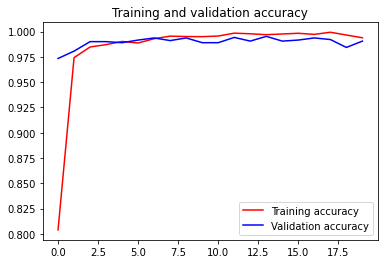

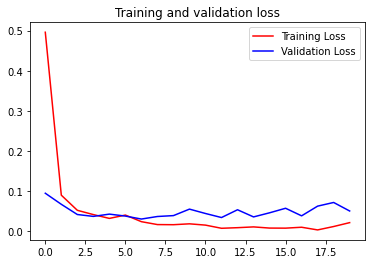

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation

In [ ]:
predictions = list(model.predict(test_generator))
ground_truth = test_generator.classes
print(predictions)
print(ground_truth)

[array([1.8931821e-09, 1.7009404e-11, 7.7959747e-08, 3.0738698e-09,
       9.9999988e-01], dtype=float32), array([1.7691398e-05, 1.0698919e-02, 5.6789001e-04, 9.8820961e-01,
       5.0588773e-04], dtype=float32), array([4.2648791e-09, 4.6964724e-12, 7.5733169e-08, 1.4254716e-09,
       9.9999988e-01], dtype=float32), array([3.8283713e-05, 2.1295430e-06, 9.9992895e-01, 8.4012655e-09,
       3.0579340e-05], dtype=float32), array([7.6961093e-10, 2.2004325e-12, 1.0000000e+00, 9.0761704e-11,
       3.2149444e-12], dtype=float32), array([1.0070848e-08, 5.9425229e-08, 7.8007433e-06, 9.9999142e-01,
       6.8236221e-07], dtype=float32), array([1.2982086e-17, 1.0000000e+00, 1.0792032e-12, 2.3127737e-15,
       3.3295899e-10], dtype=float32), array([2.4422768e-06, 2.2586141e-04, 1.3109096e-04, 9.9845421e-01,
       1.1864702e-03], dtype=float32), array([7.5779438e-11, 1.2154064e-10, 3.4697649e-08, 5.1543974e-08,
       9.9999988e-01], dtype=float32), array([1.3084582e-09, 9.9488438e-12, 1.000000

In [ ]:
lst = list()
for i in range(len(predictions)):
  lst.append(np.argmax(predictions[i]))
print(lst)

[4, 3, 4, 2, 2, 3, 1, 3, 4, 2, 0, 4, 1, 0, 1, 4, 3, 3, 1, 3, 1, 1, 0, 1, 4, 3, 4, 1, 1, 2, 4, 3, 0, 4, 3, 2, 1, 0, 2, 3, 3, 0, 1, 4, 1, 1, 2, 0, 3, 4, 4, 0, 1, 0, 2, 4, 1, 0, 0, 0, 1, 3, 3, 1, 0, 4, 2, 1, 1, 4, 2, 0, 2, 0, 1, 4, 1, 0, 2, 2, 2, 3, 4, 1, 0, 1, 0, 2, 0, 1, 1, 2, 0, 2, 4, 3, 4, 1, 2, 2, 3, 0, 2, 1, 0, 0, 2, 1, 3, 1, 4, 2, 4, 2, 3, 0, 3, 2, 4, 1, 1, 3, 4, 0, 2, 1, 2, 0, 0, 1, 0, 1, 1, 3, 3, 4, 1, 4, 1, 4, 1, 1, 4, 4, 0, 0, 1, 4, 4, 3, 1, 0, 3, 3, 1, 3, 0, 0, 4, 4, 3, 1, 3, 0, 3, 1, 3, 0, 4, 0, 3, 1, 4, 1, 1, 0, 3, 2, 1, 0, 2, 1, 3, 3, 1, 0, 0, 3, 3, 4, 4, 2, 4, 3, 2, 2, 2, 2, 0, 0, 4, 4, 1, 1, 1, 4, 4, 0, 0, 0, 2, 1, 3, 0, 4, 2, 0, 1, 1, 2, 2, 2, 1, 3, 2, 3, 0, 0, 1, 1, 1, 0, 2, 3, 4, 3, 2, 4, 1, 3, 4, 0, 1, 2, 3, 2, 3, 2, 0, 1, 1, 3, 0, 3, 4, 4, 2, 3, 3, 2, 1, 4, 1, 4, 1, 0, 2, 2, 4, 0, 3, 1, 1, 0, 1, 4, 3, 3, 3, 0, 2, 2, 0, 1, 3, 0, 0, 1, 2, 1, 3, 2, 3, 3, 4, 3, 4, 2, 2, 3, 3, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 4, 3, 4, 2, 3, 1, 3, 0, 3, 3, 4, 4, 0, 4, 0, 3, 3, 2, 4, 3, 0, 3, 

In [ ]:
evaluationa = model.evaluate(train_generator, steps=20)
evaluationb = model.evaluate(val_generator)
evaluationc = model.evaluate(test_generator)
print(evaluationa)
print(evaluationb)
print(evaluationc)

16/16 [==============================] - 51s 3s/step - loss: 0.0540 - accuracy: 0.9910
[0.025212988257408142, 0.994921863079071]
[0.049472879618406296, 0.9904999732971191]
[0.05395430698990822, 0.9909999966621399]


### Save Model

In [ ]:
model.save(os.path.join(MODEL_DIR, 'model_cnn_scenario_1'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_machine_learning/capstone_notebooks/Models/model_cnn_scenario_1/assets


## Hand-Made CNN Scenario 2

In this scenario, we'll try to convert the images to grayscale to avoid possible color bias.

### Load images using ImageDataGenerator for Scenario 2

In this scenario, we would try to load the images as `grayscale` images to avoid overfitting to mask color.

In [ ]:
# All images will be rescaled by 1./255
train_datagen2 = ImageDataGenerator(rescale=1/255)

# Flow training images in batches using train_datagen generator
train_generator2 = train_datagen.flow_from_directory(
        TRAIN_DIR,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        class_mode='categorical')

val_datagen2 = ImageDataGenerator(rescale=1/255)
val_generator2 = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        class_mode='categorical')

test_datagen2 = ImageDataGenerator(rescale=1/255)
test_generator2 = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        class_mode='categorical')

Found 10000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


### Debug dataset generators for Scenario 2

In [ ]:
# list(dir(train_generator2)) # to know what attributes and methods the generator has

In [ ]:
print('Number of classes:', train_generator2.num_classes)
print('Class map:', train_generator2.class_indices)
print('Auto-shuffle:', train_generator2.shuffle, end='\n\n')

print('Number of classes:', val_generator2.num_classes)
print('Class map:', val_generator2.class_indices)
print('Auto-shuffle:', val_generator2.shuffle, end='\n\n')

print('Number of classes:', test_generator2.num_classes)
print('Class map:', test_generator2.class_indices)
print('Auto-shuffle:', test_generator2.shuffle, end='\n\n')

Number of classes: 5
Class map: {'correctly_masked': 0, 'no_mask': 1, 'uncovered_chin': 2, 'uncovered_nose': 3, 'uncovered_nose_and_mouth': 4}
Auto-shuffle: True

Number of classes: 5
Class map: {'correctly_masked': 0, 'no_mask': 1, 'uncovered_chin': 2, 'uncovered_nose': 3, 'uncovered_nose_and_mouth': 4}
Auto-shuffle: True

Number of classes: 5
Class map: {'correctly_masked': 0, 'no_mask': 1, 'uncovered_chin': 2, 'uncovered_nose': 3, 'uncovered_nose_and_mouth': 4}
Auto-shuffle: True



Train samples 2
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)


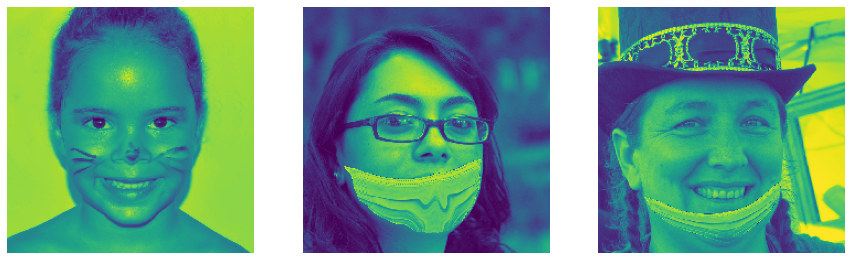

Validation samples 2
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)


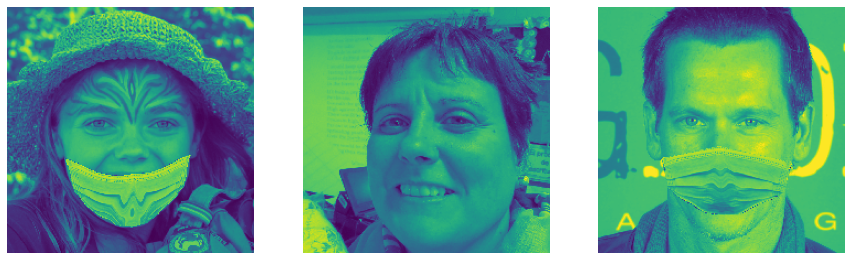

Test samples 2
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)


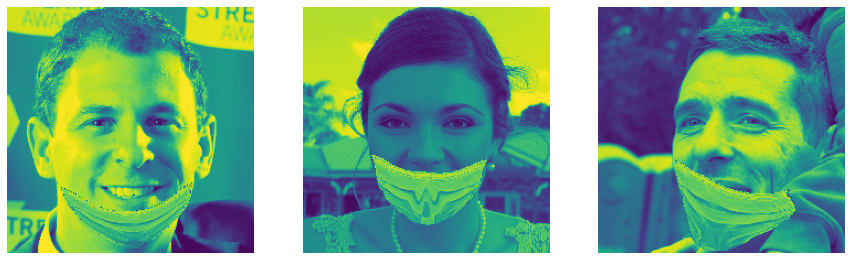

In [ ]:
# Sample some images in data generator to display

def display_samples(generator):
  '''
  Source: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
  '''
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
  for i in range(3):

    image = next(generator)[0][0]
    print(image.shape)
    image = np.reshape(image, image.shape[:2])

    ax[i].imshow(image)
    ax[i].axis('off')
  fig.show()
  plt.show()

print('Train samples 2')
display_samples(train_generator2)
print('Validation samples 2')
display_samples(val_generator2)
print('Test samples 2')
display_samples(test_generator2)

### Build Model with Hand-Made CNN Scenario 2

In this scenario, we'd create the same model as Scenario 1, but with grayscale images. Scenario 1 proves to overfit to "blue medical mask" because the dataset only consists of them. We'll try to overcome it by feeding grayscale images. Model would be compiled using `Categorical Crossentropy` loss, `Adam` optimizer, and `accuracy` metric. Because it contains relatively more shallow networks, we increase the training epochs to 20.

In [ ]:
model2 = tf.keras.models.Sequential([
    # Your Code Here
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(224, 224, 1)),
    tf.keras.layers.MaxPooling2D(4,4),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
print(model2.summary())

# Compile Model. 
model2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [ ]:
steps_train2 = train_generator2.n//BATCH_SIZE
steps_val2 = val_generator2.n//BATCH_SIZE

history2 = model2.fit(
    train_generator2,
    steps_per_epoch=steps_train2,
    validation_data=val_generator2,
    validation_steps=steps_val2,
    shuffle=True,
    epochs=20,
    verbose=1
)

Epoch 1/20
78/78 [==============================] - 4559s 59s/step - loss: 1.2350 - accuracy: 0.5024 - val_loss: 0.3197 - val_accuracy: 0.8958
Epoch 2/20
78/78 [==============================] - 316s 4s/step - loss: 0.2268 - accuracy: 0.9291 - val_loss: 0.1141 - val_accuracy: 0.9609
Epoch 3/20
78/78 [==============================] - 315s 4s/step - loss: 0.1015 - accuracy: 0.9682 - val_loss: 0.0894 - val_accuracy: 0.9724
Epoch 4/20
78/78 [==============================] - 312s 4s/step - loss: 0.0656 - accuracy: 0.9789 - val_loss: 0.0651 - val_accuracy: 0.9771
Epoch 5/20
78/78 [==============================] - 314s 4s/step - loss: 0.0436 - accuracy: 0.9875 - val_loss: 0.0549 - val_accuracy: 0.9802
Epoch 6/20
78/78 [==============================] - 312s 4s/step - loss: 0.0385 - accuracy: 0.9893 - val_loss: 0.0732 - val_accuracy: 0.9776
Epoch 7/20
78/78 [==============================] - 312s 4s/step - loss: 0.0334 - accuracy: 0.9908 - val_loss: 0.0469 - val_accuracy: 0.9844
Epoch 8/20


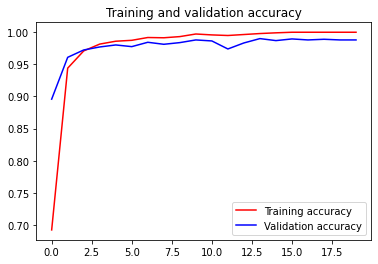

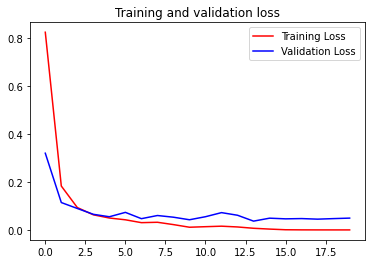

In [ ]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs = range(len(acc2))

plt.plot(epochs, acc2, 'r', label='Training accuracy')
plt.plot(epochs, val_acc2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss2, 'r', label='Training Loss')
plt.plot(epochs, val_loss2, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation

In [ ]:
predictions2 = list(model2.predict(test_generator2))
ground_truth = test_generator2.classes
print(predictions2)
print(ground_truth)

[array([8.9322013e-15, 2.5615632e-09, 4.5612396e-13, 4.1549877e-10,
       1.0000000e+00], dtype=float32), array([9.0637887e-15, 8.5114705e-05, 4.9991597e-13, 4.3908052e-10,
       9.9991488e-01], dtype=float32), array([1.0000000e+00, 5.9457821e-12, 3.4373188e-11, 1.7755920e-17,
       1.1736629e-15], dtype=float32), array([6.1160923e-13, 1.8572009e-10, 5.2765237e-10, 2.4754038e-07,
       9.9999976e-01], dtype=float32), array([1.4140788e-07, 9.9999475e-01, 6.7358279e-11, 6.0142082e-12,
       5.1447610e-06], dtype=float32), array([4.4577783e-10, 1.0000000e+00, 3.6794335e-12, 2.4726870e-12,
       9.9523367e-12], dtype=float32), array([2.2956969e-07, 9.9999964e-01, 1.3430335e-08, 9.1950110e-09,
       8.4697319e-08], dtype=float32), array([1.4880913e-17, 8.6516667e-17, 2.9524799e-15, 1.0000000e+00,
       5.5080873e-10], dtype=float32), array([3.8892509e-12, 2.8051931e-12, 3.8265044e-10, 9.9999964e-01,
       3.7219542e-07], dtype=float32), array([3.2037334e-10, 2.7705832e-12, 1.000000

In [ ]:
lst = list()
for i in range(len(predictions2)):
  lst.append(np.argmax(predictions2[i]))
print(lst)

[4, 4, 0, 4, 1, 1, 1, 3, 3, 2, 4, 0, 3, 4, 0, 1, 2, 1, 4, 3, 4, 1, 2, 0, 0, 1, 2, 2, 0, 3, 1, 3, 4, 1, 1, 3, 2, 2, 4, 1, 3, 3, 2, 3, 3, 4, 3, 1, 4, 3, 4, 4, 1, 1, 3, 2, 4, 3, 1, 4, 2, 4, 4, 4, 1, 2, 0, 4, 1, 3, 2, 3, 0, 3, 3, 4, 2, 0, 2, 3, 4, 4, 1, 4, 2, 2, 3, 2, 2, 2, 4, 2, 4, 0, 3, 2, 2, 0, 2, 3, 0, 1, 3, 0, 2, 0, 4, 0, 0, 4, 0, 2, 1, 1, 0, 4, 3, 4, 0, 3, 1, 0, 1, 4, 0, 0, 3, 1, 3, 0, 4, 1, 0, 4, 4, 2, 2, 0, 3, 2, 0, 1, 2, 4, 2, 2, 0, 1, 0, 1, 1, 2, 2, 3, 1, 3, 4, 2, 3, 0, 3, 0, 1, 2, 1, 2, 4, 0, 2, 4, 2, 4, 0, 1, 2, 2, 1, 4, 1, 1, 0, 2, 4, 0, 4, 3, 2, 2, 2, 2, 1, 4, 1, 3, 0, 0, 3, 3, 2, 3, 3, 1, 2, 0, 3, 0, 2, 2, 4, 1, 3, 0, 2, 2, 2, 4, 2, 0, 4, 0, 2, 2, 3, 4, 4, 2, 3, 0, 2, 0, 2, 1, 2, 4, 2, 3, 3, 0, 4, 1, 3, 3, 3, 2, 4, 4, 4, 1, 3, 1, 2, 0, 1, 1, 0, 4, 3, 1, 0, 3, 0, 0, 0, 0, 0, 3, 1, 1, 4, 2, 1, 1, 1, 2, 3, 0, 2, 2, 2, 3, 3, 3, 3, 0, 1, 4, 4, 1, 4, 2, 0, 1, 0, 4, 1, 0, 3, 2, 3, 2, 3, 3, 2, 4, 2, 3, 1, 4, 2, 3, 4, 4, 0, 2, 2, 4, 4, 1, 4, 0, 1, 4, 3, 4, 3, 3, 2, 0, 1, 4, 2, 2, 1, 

In [ ]:
evaluation2a = model2.evaluate(train_generator2, steps=20)
evaluation2b = model2.evaluate(val_generator2)
evaluation2c = model2.evaluate(test_generator2)
print(evaluation2a)
print(evaluation2b)
print(evaluation2c)

16/16 [==============================] - 50s 3s/step - loss: 0.0621 - accuracy: 0.9905
[5.6722219596849754e-05, 1.0]
[0.04731220006942749, 0.9884999990463257]
[0.06214987114071846, 0.9904999732971191]


### Save Model

In [ ]:
model2.save(os.path.join(MODEL_DIR, 'model_cnn_grayscale_scenario_2'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_machine_learning/capstone_notebooks/Models/model_cnn_grayscale_scenario_2/assets


### Test Model with upload image

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

Saving mask3.jpg to mask3.jpg
Saving mask2.png to mask2.png
Saving mask1.jpg to mask1.jpg


In [ ]:
demo_datagen = ImageDataGenerator(rescale=1/255)
demo_generator = test_datagen.flow_from_directory(
    '/content/images/',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical')

NameError: ignored

In [ ]:
classes = model.predict(demo_generator)

print(classes)
for i in classes:
    print(np.argmax(i))

[[9.9950135e-01 5.9536642e-08 3.5659273e-04 1.7353657e-09 1.4206143e-04]
 [1.1254932e-07 9.9992251e-01 1.2825441e-06 4.8046580e-09 7.6080971e-05]
 [8.7883276e-13 9.9999964e-01 1.9447870e-09 7.8169299e-10 3.6514277e-07]]
0
1
1


## Hand-Made CNN Scenario 3

In this scenario, we'll try to use new dataset with more variety of masks, but also various image shapes & sizes.

### Load images using ImageDataGenerator for Scenario 3

In [ ]:
DATASET_DIR3 = '/content/drive/MyDrive/capstone_machine_learning/masked_face_classification/dataset/kaggle/kaggle_dataset/data' # Change based on dataset dir on your system/device

In [ ]:
# All images will be rescaled by 1./255
datagen3 = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

train_generator3 = datagen3.flow_from_directory(
        DATASET_DIR3,
        target_size=(224, 224),
        color_mode='rgba',
        batch_size=BATCH_SIZE,
        subset='training',
        classes=['without_mask', 'with_mask'],
        class_mode='binary')

val_generator3 = datagen3.flow_from_directory(
        DATASET_DIR3,
        shuffle=False,
        target_size=(224, 224),
        color_mode='rgba',
        batch_size=BATCH_SIZE,
        subset='validation',
        classes=['without_mask', 'with_mask'],
        class_mode='binary')

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


### Debug dataset generators for Scenario 3

In [ ]:
# list(dir(train_generator3)) # to know what attributes and methods the generator has

In [ ]:
print('Number of classes:', train_generator3.num_classes)
print('Class map:', train_generator3.class_indices)
print('Auto-shuffle:', train_generator3.shuffle, end='\n\n')

print('Number of classes:', val_generator3.num_classes)
print('Class map:', val_generator3.class_indices)
print('Auto-shuffle:', val_generator3.shuffle, end='\n\n')

Number of classes: 2
Class map: {'without_mask': 0, 'with_mask': 1}
Auto-shuffle: True

Number of classes: 2
Class map: {'without_mask': 0, 'with_mask': 1}
Auto-shuffle: True



Train samples 3
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


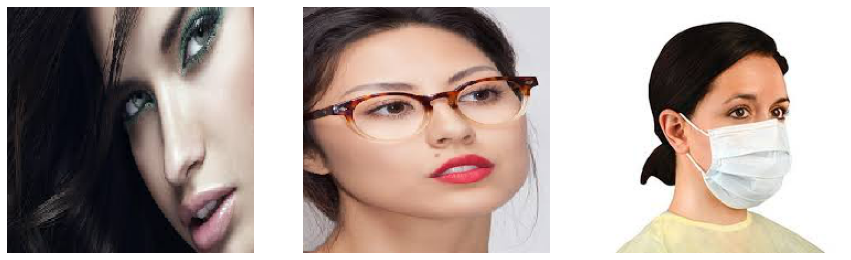

Validation samples 3
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


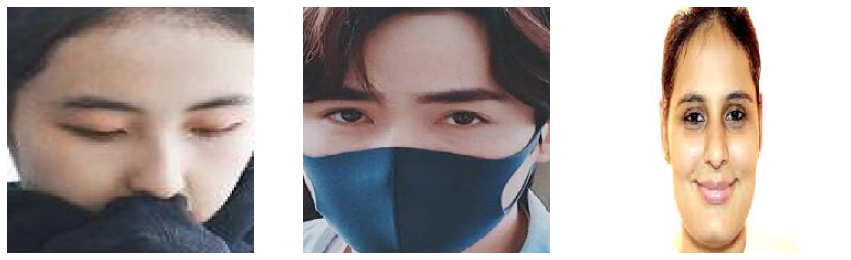

In [ ]:
# Sample some images in data generator to display

def display_samples3(generator):
  '''
  Source: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
  '''
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
  for i in range(3):

    image = next(generator)[0][0]
    print(image.shape)

    ax[i].imshow(image)
    ax[i].axis('off')
  fig.show()
  plt.show()

print('Train samples 3')
display_samples3(train_generator3)
print('Validation samples 3')
display_samples3(val_generator3)

### Build Model with Hand-Made CNN Scenario 3

In this scenario, we'd create the same model as __Scenario 1__, but for new dataset. Model would be compiled using `Binary Crossentropy` loss, `Adam` optimizer, and `accuracy` metric. Because the dataset is smaller, we increase the training epochs to 50.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model3 = tf.keras.models.Sequential([
    # Your Code Here
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(224, 224, 4)),
    tf.keras.layers.MaxPooling2D(4,4),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
print(model3.summary())

# Compile Model. 
model3.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      3232      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [ ]:
steps_train = train_generator3.n//BATCH_SIZE
steps_val = val_generator3.n//BATCH_SIZE

history3 = model3.fit(
    train_generator3,
    steps_per_epoch=steps_train,
    validation_data=val_generator3,
    validation_steps=steps_val,
    shuffle=True,
    epochs=50,
    verbose=1
)

Epoch 1/50
47/47 [==============================] - 36s 757ms/step - loss: 0.5272 - accuracy: 0.7219 - val_loss: 0.2829 - val_accuracy: 0.8942
Epoch 2/50
47/47 [==============================] - 35s 743ms/step - loss: 0.2910 - accuracy: 0.8840 - val_loss: 0.2707 - val_accuracy: 0.8977
Epoch 3/50
47/47 [==============================] - 35s 732ms/step - loss: 0.2519 - accuracy: 0.8950 - val_loss: 0.2518 - val_accuracy: 0.9119
Epoch 4/50
47/47 [==============================] - 35s 742ms/step - loss: 0.2155 - accuracy: 0.9150 - val_loss: 0.2233 - val_accuracy: 0.9112
Epoch 5/50
47/47 [==============================] - 35s 738ms/step - loss: 0.1969 - accuracy: 0.9232 - val_loss: 0.2208 - val_accuracy: 0.9162
Epoch 6/50
47/47 [==============================] - 34s 735ms/step - loss: 0.1698 - accuracy: 0.9347 - val_loss: 0.1481 - val_accuracy: 0.9510
Epoch 7/50
47/47 [==============================] - 34s 734ms/step - loss: 0.1612 - accuracy: 0.9371 - val_loss: 0.1675 - val_accuracy: 0.9439

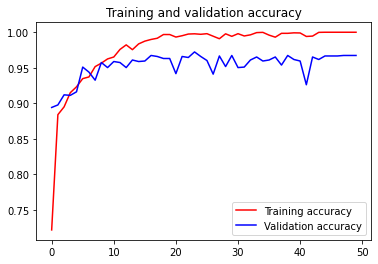

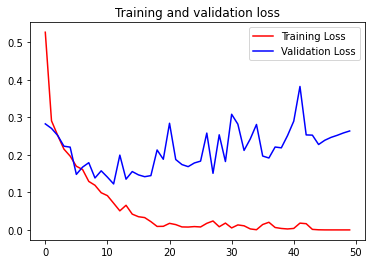

In [ ]:
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs3 = range(len(acc3))

plt.plot(epochs3, acc3, 'r', label='Training accuracy')
plt.plot(epochs3, val_acc3, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs3, loss3, 'r', label='Training Loss')
plt.plot(epochs3, val_loss3, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation

In [ ]:
predictions3 = tf.round(model3.predict(val_generator3)).numpy()
predictions3 = np.reshape(predictions3, predictions3.shape[:-1])
ground_truth3 = val_generator3.classes
print(predictions3)
print(ground_truth3)

[0. 0. 0. ... 0. 1. 1.]
[0 0 0 ... 1 1 1]


In [ ]:
evaluation3a = model3.evaluate(train_generator3)
evaluation3b = model3.evaluate(val_generator3)
print(evaluation3a)
print(evaluation3b)

12/12 [==============================] - 5s 456ms/step - loss: 0.2537 - accuracy: 0.9675
[1.3942094483354595e-05, 1.0]
[0.2537429630756378, 0.9675496816635132]


### Save Model

In [ ]:
model3.save(os.path.join(MODEL_DIR, 'model_cnn_scenario_3.h5'))

### Test Model with upload new image

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving 00126_Mask_Mouth_Chin.jpg to 00126_Mask_Mouth_Chin.jpg
Saving 00365_Mask_Chin.jpg to 00365_Mask_Chin.jpg
Saving 00454_Mask_Nose_Mouth.jpg to 00454_Mask_Nose_Mouth.jpg
Saving 20210515_105130.jpg to 20210515_105130.jpg
Saving 20210515_105240.jpg to 20210515_105240.jpg
Saving 20210515_105301.jpg to 20210515_105301.jpg
Saving 20210515_105310.jpg to 20210515_105310.jpg
Saving 20210515_105324.jpg to 20210515_105324.jpg
Saving 20210520_102134.jpg to 20210520_102134.jpg
Saving 20210520_102204.jpg to 20210520_102204.jpg
Saving 20210520_102225.jpg to 20210520_102225.jpg
Saving 20210520_102238.jpg to 20210520_102238.jpg
Saving mask_no-mask1.jpg to mask_no-mask1.jpg
Saving mask2.png to mask2.png
Saving mask3.jpg to mask3.jpg


In [ ]:
demo_datagen3 = ImageDataGenerator(rescale=1/255)
demo_generator3 = demo_datagen3.flow_from_directory(
    '/content/any_folder/', # Ganti sesuai gambar yang mau dipredict ada di mana di filesystem
    shuffle=False,
    target_size=(224, 224),
    color_mode='rgba',
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 15 images belonging to 2 classes.


(224, 224, 4)
(224, 224, 4)
(224, 224, 4)


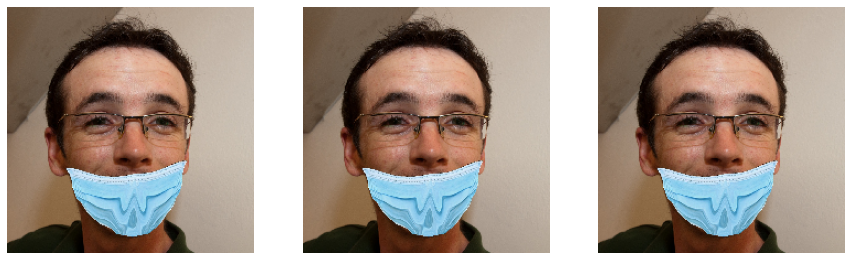

In [ ]:
def display_demo_samples(generator):
  '''
  Source: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
  '''
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
  for i in range(3):

    image = next(generator)[0][0]
    # image = np.reshape(image, image.shape[:2])
    print(image.shape)

    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')
  fig.show()
  plt.show()

display_demo_samples(demo_generator3)

In [ ]:
classes3 = tf.round(model3.predict(demo_generator3))

for i in classes3:
    print(i)

tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)


## Hand-Made CNN Scenario 4

In this scenario, we'll use the new dataset with deeper CNN.

### Load images using ImageDataGenerator for Scenario 4

In [ ]:
DATASET_DIR4 = '/content/drive/MyDrive/capstone_machine_learning/masked_face_classification/dataset/kaggle/kaggle_dataset/data' # Change based on dataset dir on your system/device

In [ ]:
# All images will be rescaled by 1./255
datagen4 = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

train_generator4 = datagen4.flow_from_directory(
        DATASET_DIR4,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        subset='training',
        classes=['without_mask', 'with_mask'],
        class_mode='binary')

val_generator4 = datagen4.flow_from_directory(
        DATASET_DIR4,
        shuffle=False,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        subset='validation',
        classes=['without_mask', 'with_mask'],
        class_mode='binary')

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


### Build Model with Hand-Made CNN Scenario 4

In this scenario, we'd deeper model than __Scenario 3__. Model would be compiled using `Binary Crossentropy` loss, `Adam` optimizer, and `accuracy` metric.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model4 = tf.keras.models.Sequential([
    # Your Code Here
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(4,4),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
print(model4.summary())

# Compile Model. 
model4.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [ ]:
steps_train = train_generator4.n//BATCH_SIZE
steps_val = val_generator4.n//BATCH_SIZE

history4 = model4.fit(
    train_generator4,
    steps_per_epoch=steps_train,
    validation_data=val_generator4,
    validation_steps=steps_val,
    shuffle=True,
    epochs=50,
    verbose=1
)

Epoch 1/50
14/47 [=======>......................] - ETA: 17s - loss: 0.6188 - accuracy: 0.6456

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


47/47 [==============================] - 31s 652ms/step - loss: 0.4655 - accuracy: 0.7806 - val_loss: 0.2693 - val_accuracy: 0.8970
Epoch 2/50
47/47 [==============================] - 31s 651ms/step - loss: 0.2588 - accuracy: 0.9003 - val_loss: 0.2431 - val_accuracy: 0.9141
Epoch 3/50
47/47 [==============================] - 31s 650ms/step - loss: 0.1961 - accuracy: 0.9256 - val_loss: 0.2056 - val_accuracy: 0.9155
Epoch 4/50
47/47 [==============================] - 30s 648ms/step - loss: 0.1734 - accuracy: 0.9390 - val_loss: 0.1922 - val_accuracy: 0.9325
Epoch 5/50
47/47 [==============================] - 31s 653ms/step - loss: 0.1340 - accuracy: 0.9518 - val_loss: 0.2063 - val_accuracy: 0.9283
Epoch 6/50
47/47 [==============================] - 31s 649ms/step - loss: 0.1108 - accuracy: 0.9591 - val_loss: 0.1969 - val_accuracy: 0.9361
Epoch 7/50
47/47 [==============================] - 31s 651ms/step - loss: 0.0862 - accuracy: 0.9714 - val_loss: 0.2160 - val_accuracy: 0.9389
Epoch 8/50

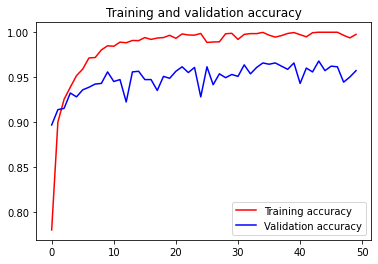

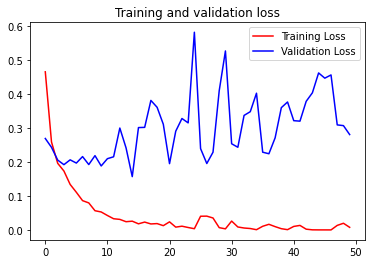

In [ ]:
acc4 = history4.history['accuracy']
val_acc4 = history4.history['val_accuracy']
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

epochs4 = range(len(acc4))

plt.plot(epochs4, acc4, 'r', label='Training accuracy')
plt.plot(epochs4, val_acc4, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs4, loss4, 'r', label='Training Loss')
plt.plot(epochs4, val_loss4, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation

In [ ]:
predictions4 = tf.round(model4.predict(val_generator4)).numpy()
predictions4 = np.reshape(predictions4, predictions4.shape[:-1])
ground_truth4 = val_generator4.classes
print(predictions4)
print(ground_truth4)

[1. 0. 0. ... 1. 1. 1.]
[0 0 0 ... 1 1 1]


In [ ]:
evaluation4a = model4.evaluate(train_generator4)
evaluation4b = model4.evaluate(val_generator4)
print(evaluation4a)
print(evaluation4b)

 3/48 [>.............................] - ETA: 23s - loss: 4.5703e-04 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


12/12 [==============================] - 5s 430ms/step - loss: 0.2627 - accuracy: 0.9596
[0.0038812411949038506, 0.9986761808395386]
[0.2626553475856781, 0.9596026539802551]


### Save Model

In [ ]:
model4.save(os.path.join(MODEL_DIR, 'model_cnn_scenario_4.h5'))

### Test Model with upload new image

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
demo_datagen4 = ImageDataGenerator(rescale=1/255)
demo_generator4 = demo_datagen4.flow_from_directory(
    '/content/any_folder/', # Ganti sesuai gambar yang mau dipredict ada di mana di filesystem
    shuffle=False,
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary')

Found 8 images belonging to 2 classes.


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


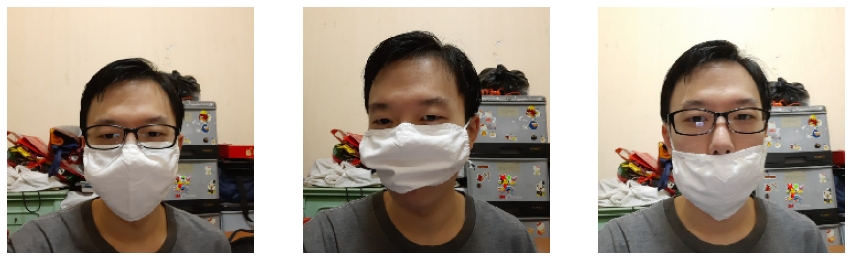

In [ ]:
def display_demo_samples(generator):
  '''
  Source: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
  '''
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
  for i in range(3):

    image = next(generator)[0][0]
    # image = np.reshape(image, image.shape[:2])
    print(image.shape)

    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')
  fig.show()
  plt.show()

display_demo_samples(demo_generator4)

In [ ]:
classes4 = tf.round(model4.predict(demo_generator4))

for i in classes4:
    print(i)

tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)


## Hand-Made CNN Scenario 5

In this scenario, we'll use the third dataset. We use base data generator in early section.

### Build Model with Hand-Made CNN Scenario 5

In this scenario, we'd use same model as __Scenario 4__. Model would be compiled using `Binary Crossentropy` loss, `Adam` optimizer, and `accuracy` metric.

In [15]:
tf.keras.backend.clear_session()

In [16]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(4,4),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(1024, activation='relu'),
    # tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
print(model5.summary())

# Compile Model. 
model5.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [17]:
steps_train = train_generator.n//BATCH_SIZE
steps_val = val_generator.n//BATCH_SIZE

history5 = model5.fit(
    train_generator,
    steps_per_epoch=steps_train,
    validation_data=val_generator,
    validation_steps=steps_val,
    shuffle=True,
    epochs=50,
    verbose=1
)

Epoch 1/50
4/4 [==============================] - 12s 3s/step - loss: 0.6978 - accuracy: 0.4767 - val_loss: 0.7011 - val_accuracy: 0.4023
Epoch 2/50
4/4 [==============================] - 9s 3s/step - loss: 0.6456 - accuracy: 0.6377 - val_loss: 0.5997 - val_accuracy: 0.8008
Epoch 3/50
4/4 [==============================] - 9s 3s/step - loss: 0.4946 - accuracy: 0.8559 - val_loss: 0.4241 - val_accuracy: 0.8359
Epoch 4/50
4/4 [==============================] - 9s 3s/step - loss: 0.3720 - accuracy: 0.8305 - val_loss: 0.7542 - val_accuracy: 0.6641
Epoch 5/50
4/4 [==============================] - 9s 3s/step - loss: 0.3583 - accuracy: 0.8411 - val_loss: 0.2987 - val_accuracy: 0.8867
Epoch 6/50
4/4 [==============================] - 9s 3s/step - loss: 0.2782 - accuracy: 0.8919 - val_loss: 0.3070 - val_accuracy: 0.8906
Epoch 7/50
4/4 [==============================] - 9s 3s/step - loss: 0.2809 - accuracy: 0.8983 - val_loss: 0.2735 - val_accuracy: 0.9062
Epoch 8/50
4/4 [========================

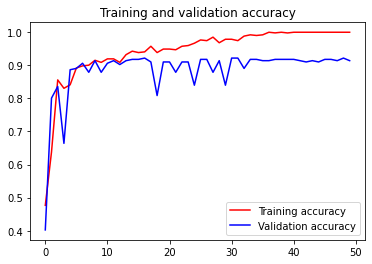

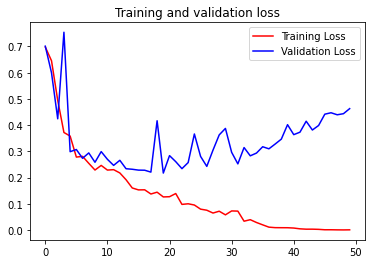

In [18]:
acc5 = history5.history['accuracy']
val_acc5 = history5.history['val_accuracy']
loss5 = history5.history['loss']
val_loss5 = history5.history['val_loss']

epochs5 = range(len(acc5))

plt.plot(epochs5, acc5, 'r', label='Training accuracy')
plt.plot(epochs5, val_acc5, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs5, loss5, 'r', label='Training Loss')
plt.plot(epochs5, val_loss5, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation

In [19]:
predictions5 = tf.round(model5.predict(test_generator)).numpy()
predictions5 = np.reshape(predictions5, predictions5.shape[:-1])
ground_truth5 = test_generator.classes
print(predictions5)
print(ground_truth5)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [20]:
evaluation5a = model5.evaluate(train_generator)
evaluation5b = model5.evaluate(val_generator)
evaluation5c = model5.evaluate(test_generator)
print(evaluation5a)
print(evaluation5b)
print(evaluation5c)

1/1 [==============================] - 1s 1s/step - loss: 0.2380 - accuracy: 0.9400
[0.0003962810442317277, 1.0]
[0.5522781610488892, 0.9052287340164185]
[0.23802804946899414, 0.9399999976158142]


### Save Model

In [21]:
model5.save(os.path.join(MODEL_DIR, 'model_cnn_scenario_5.h5'))

### Test Model with upload new image

In [22]:
from google.colab import files

uploaded = files.upload()

Saving 00126_Mask_Mouth_Chin.jpg to 00126_Mask_Mouth_Chin.jpg
Saving 00365_Mask_Chin.jpg to 00365_Mask_Chin.jpg
Saving 00454_Mask_Nose_Mouth.jpg to 00454_Mask_Nose_Mouth.jpg
Saving 20210515_105130.jpg to 20210515_105130.jpg
Saving 20210515_105240.jpg to 20210515_105240.jpg
Saving 20210515_105301.jpg to 20210515_105301.jpg
Saving 20210515_105310.jpg to 20210515_105310.jpg
Saving 20210515_105333.jpg to 20210515_105333.jpg
Saving 20210520_102134.jpg to 20210520_102134.jpg
Saving 20210520_102212.jpg to 20210520_102212.jpg
Saving 20210520_102225.jpg to 20210520_102225.jpg
Saving 20210520_102238.jpg to 20210520_102238.jpg
Saving mask_no-mask1.jpg to mask_no-mask1.jpg
Saving mask1.jpg to mask1.jpg
Saving mask2.png to mask2.png
Saving mask3.jpg to mask3.jpg


In [23]:
for i in os.listdir("./"):
  if i.endswith(('.jpg', '.png')):
    src_dir = "./"
    dest_dir = "./any_folder/any_subfolder/"
    os.rename(os.path.join(src_dir, i), os.path.join(dest_dir, i))

In [24]:
demo_datagen5 = ImageDataGenerator(rescale=1/255)
demo_generator5 = demo_datagen5.flow_from_directory(
    '/content/any_folder/', # Ganti sesuai gambar yang mau dipredict ada di mana di filesystem
    shuffle=False,
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary')

Found 16 images belonging to 2 classes.


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


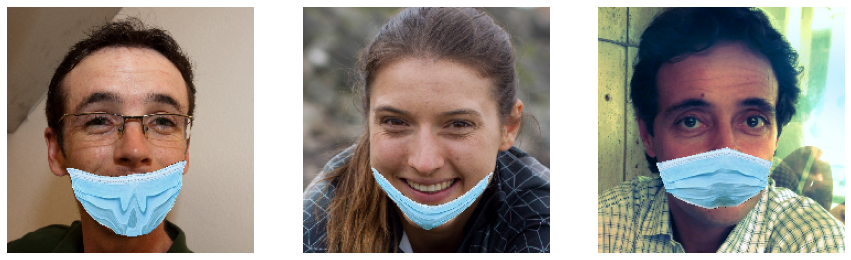

In [25]:
def display_demo_samples(generator):
  '''
  Source: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
  '''
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
  for i in range(3):

    image = next(generator)[0][0]
    # image = np.reshape(image, image.shape[:2])
    print(image.shape)

    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')
  fig.show()
  plt.show()

display_demo_samples(demo_generator5)

In [26]:
classes5 = tf.round(model5.predict(demo_generator5))

for i in classes5:
    print(i)

tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
